Este notebook contém um código que implementa a PINN da solução de Schwarzschild (um corpo massivo em um espaço-tempo estático e esfericamente simétrico).

Além disso, coloquei no repositório um PDF mostrando os gráficos das soluções exatas de $A(r)$ e $B(r)$ gerados no Mathemathica. Nele é possível observar o comportamento dessas funções na origem.

# **Descrição do problema**

A solução de Schwarzschild descreve um espaço-tempo no vácuo sob a influência de um objeto massivo, sem rotação e esfericamente simétrico. Para obter a métrica de Schwarzschild, assumimos coordenadas esféricas $(t, r, \theta, \phi)$.

Se a solução é no vácuo, então $T_{\mu \nu} = 0 \to R_{\mu \nu} = 0$ e $R = 0$. Além disso, note que: $\frac{\partial}{\partial t}g_{\mu \nu} = 0$. Portanto, dada a simetria do problema, temos que:

$g_{\mu \nu} = 0$ $(\mu \ne \nu)$

Dessa forma, a métrica deve ser do tipo:

$ds^2 = g_{11} dr^2 + g_{22} d\theta^2 + g_{33} d\phi^2 + g_{44} dt^2$.

Se fatiarmos o espaço-tempo em hipersuperfícies e considerarmos que em cada hipersuperfície de tempo constante, $t = cte.$, $\theta = cte.$ e $\phi = cte.$, há simetria esférica, então:

$g_{11} = A(r)$,

$g_{44} = B(r)$

e para uma métrica de fundo em coordenadas esféricas:

$g_{22} = r^2sin^2\theta$.

Portanto, $A(r)$ e $B(r)$ são as funções a serem determinadas.

Se considerarmos que asssintoticamente o espaço-tempo deve ser plano, então a forma final da métrica é:

$ds^2 = A(r)dr^2 + r^2d\theta^2 + r^2sin^2\theta d\phi^2 + B(r)dt^2$.

Para determinar as funções desconhecidas, calculamos primeiramente as conexões e o tensor de Ricci:

$ R_{tt} = -\frac{1}{4} \frac{B'}{A} \left( \frac{A'}{A} - \frac{B'}{B} + \frac{4}{r} \right)  - \frac{1}{2}\left(\frac{B'}{A} \right)' $,

$ R_{rr} = -\frac{1}{2} \left( \frac{B'}{B} \right)' - \frac{1}{4} \left( \frac{B'}{B} \right)^2 + \frac{1}{4}\frac{A'}{A}\left(\frac{B'}{B} + \frac{1}{4} \right) $,

$ R_{\theta \theta} = 1 -\left( \frac{r}{A} \right)' - \frac{r}{2A} \left( \frac{A'}{A} + \frac{B'}{B} \right) $,

$ R_{\phi \phi} = sin^2(\theta) R_{\theta \theta} $.

Simplificando, obtemos o seguinte sistema de EDO's:

$4A'B^2 - 2rABB'' + rA'BB' + rAB'^2 = 0$,

$-2rABB'' + rA'BB' + rAB'^2 - 4ABB' = 0$,

$rA'B + 2A^2B - 2AB - rAB' = 0$.

Da literatura conhecemos a solução exata:

$ A(r) = \left( 1 - \frac{2\mu}{r} \right)^{-1} ~~\mathrm{e}~~ B(r) = -c^2 \left( 1 - \frac{2\mu}{r} \right)$,

onde fizemos: $\mu = \frac{Gm}{c^2}$.

Assumindo o sistema geométrico: $G = c = 1 \to \mu = m$ (massa do objeto), então:

$ A(r) = \left( 1 - \frac{2\mu}{r} \right)^{-1} ~~\mathrm{e}~~ B(r) = - \left( 1 - \frac{2\mu}{r} \right)$.

Note que para valores de $r = 2 \mu$ temos que a função $A(r)$ diverge. Esse valor é chamado de raio de Schwarzschild e numericamente deve ser tratado com cuidado, no sentido de que, à medida que nos aproximamos do raio de Schwarzschild a precisão numérica fica comprometida.

Observe as derivadas de $A(r)$ e $B(r)$:

$\frac{dA}{dr} = -4 \frac{\mu}{r^2} \left(1 - \frac{2\mu}{r}\right)^{-3}$,


$\frac{dB}{dr} = -\frac{2\mu}{r^2}
$,

$\frac{d^2B}{dr^2} = \frac{4\mu}{r^3}
$.

Além disso, consideramos as seguintes condições de contorno:

$A(r \to \infty) = 1$,

$B(r \to \infty) = -1$

para encontrar a solução do sistema de EDOs.


A ideia é configurar uma PINN para resolver o sistema de equações acima, considerando como condição de contorno que a métrica deve ser plana no infinito. Nesse sentido, as equações diferenciais subjacentes reforçam a Função Loss e a rede neural deve minimizar o resíduo da equação diferencial.

Assim como no caso do OHA, treinamos uma rede neural padrão para ter uma ideia noção das configurações da rede que levam à convergência da solução da EDO. Logo mais, treinamos uma PINN para extrapolar a solução para além dos dados de treino (condições de contorno) minimizando o resíduo do sistema de EDOs.

# **Configurações gerais**

In [ ]:
# chama os módulos necessários

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from __future__ import division, print_function
import sys
from PIL import Image

In [ ]:
# mostra a solução exata de Schwarzschild

def exact_solution(r, mu):
    A = (1 - 2*mu/r)**(-1)
    B = -(1 - 2*mu/r)
    return np.array([A,B], float)

In [ ]:
# configura a rede neural de conexão direta (multilayer perceptron)

class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, r):
        r = self.fcs(r)
        r = self.fch(r)
        r = self.fce(r)
        return r

In [ ]:
# mostra os gráficos das soluções exata e aproximada

def plot_result(r, y, r_data, y_data, y_pred, r_pred = None):

    plt.figure(figsize = (8,4))

    plt.plot(r, y_pred[:, 0], color = "tab:red", linewidth = 2, alpha = 0.8, label = "Predição da $RN_A$")
    plt.plot(r, y_pred[:, 1], color = "tab:pink", linewidth = 2, alpha = 0.8, label = "Predição da $RN_B$")
    plt.plot(r[19:], y[19:, 0], color = "blue", linewidth = 2, alpha = 0.8,linestyle = "--",label = "Solução exata A")
    plt.plot(r[19:], y[19:, 1], color = "gray", linewidth = 2, alpha = 0.8,linestyle = "--",label = "Solução exata B")
    plt.scatter(r_data, y_data[:, 0], s = 60, color = "green", alpha = 0.4, label = "Dados de treino A")
    plt.scatter(r_data, y_data[:, 1], s = 60, color = "green", alpha = 0.4, label = "Dados de treino B")
    if r_pred is not None:
        plt.scatter(r_pred, -0*torch.ones_like(r_pred), s = 30, color = "tab:purple", alpha = 0.4,
                    label = "Pontos de colocação")
    l = plt.legend(loc = (1.0,0.20), frameon = False, fontsize = "large")
    plt.setp(l.get_texts(), color = "k")
    plt.xlim(-0.05, 105)
    plt.ylim(-1.5, 3)
    plt.text(106.5, 2.6, "Estágio: %i"%(i+1), fontsize = "xx-large", color = "k")
    plt.ylabel("A(r), B(r)", fontsize = "x-large")
    plt.xlabel("$r$", fontsize = "x-large")
    plt.axis("on")

# **Obtenção dos dados de treino a partir a solução exata**

torch.Size([499, 1]) torch.Size([499, 1]) torch.Size([499, 1])
torch.Size([9, 1]) torch.Size([9, 1]) torch.Size([9, 1]) torch.Size([9, 2])


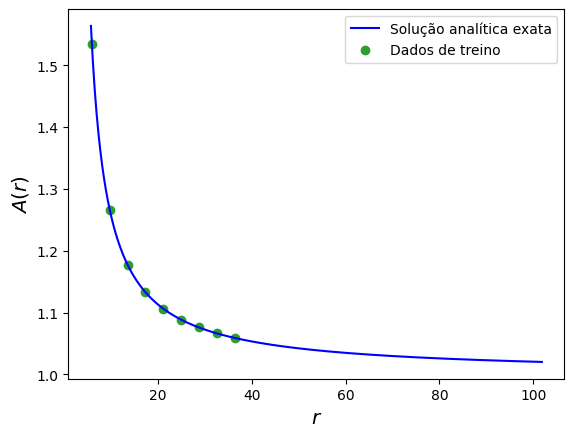

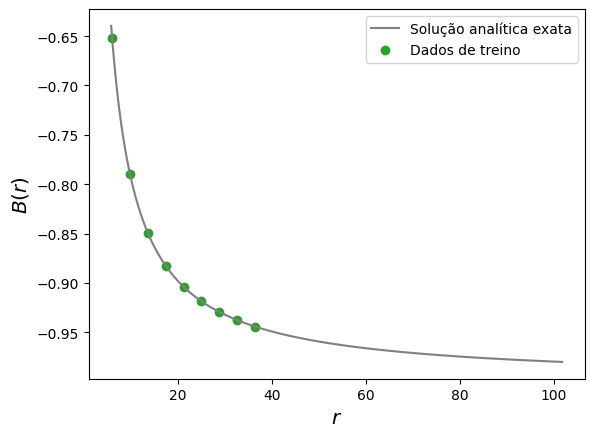

In [ ]:
# configuração dos dados

n_steps = 500
mu = 1.009      # esse valor permite lidar melhor com as divergências na origem
r_min, r_max = 2, 102
r_step = (r_max - r_min)/n_steps

r_points = np.arange(r_min, r_max, r_step)
A_points, B_points = [], []

# condições de contorno

A0, B0 = 10, 0
S = np.array([A0, B0], float)

# obtém a solução exata

for r in r_points:
    A_points += [S[0]]
    B_points += [S[1]]
    S = exact_solution(r, mu)

# converte listas para tensores

r = torch.Tensor(r_points[1:]).view(-1, 1)
A = torch.Tensor(A_points[1:]).view(-1, 1)
B = torch.Tensor(B_points[1:]).view(-1, 1)
print(r.shape, A.shape, B.shape)

# concatena os valores de A e B

y = torch.cat((A, B), 1)

# # coleta 10 pontos da solução exata para comparações posteriores

# r1 = r[::10]
# A1 = A[::10, :]
# B1 = B[::10, :]
# y1 = y[::10, :]

# print(r1.shape, A1.shape, B1.shape, y1.shape)

# coleta 10 pontos da solução exata para treino da rede neural padrão

r_data = r[19:190:19]
A_data = A[19:190:19]
B_data = B[19:190:19]
y_data = y[19:190:19, :]

print(r_data.shape, A_data.shape, B_data.shape, y_data.shape)

# gráfico da solução exata vs dados de treino

plt.figure()
plt.plot(r_points[19:], A_points[19:], color = "blue", label = "Solução analítica exata")
plt.scatter(r_data, y_data[:,0], color = "tab:green", label = "Dados de treino")
plt.xlabel("$r$", fontsize = "x-large")
plt.ylabel("$A(r)$", fontsize = "x-large")
plt.legend()
plt.show()

plt.figure()
plt.plot(r_points[19:], B_points[19:], color = "gray", label = "Solução analítica exata")
plt.scatter(r_data, y_data[:,1], color = "tab:green", label = "Dados de treino")
plt.xlabel("$r$", fontsize = "x-large")
plt.ylabel("$B(r)$", fontsize = "x-large")
plt.legend()
plt.show()

# **Treino da rede neural padrão**

Vamos configurar um MLP com $1$ camada de entrada e de saída, ambas de tamanho $1$, $3$ camadas ocultas e $32$ neurônios em cada uma delas: $model = FCN(1, 2, 32, 3)$. O learning rate é da ordem de $10^{-4}$. Durante o treino, os parâmetros do modelo são otimizados com o otimizador $Adam$. A acurácia dos dados previstos é obtida calculando os $MSE$ (Mean Squared Error), $MAE$ (Mean Absolute Error) e fator $R^2$, medidos entre os dados previstos e a solução exata.

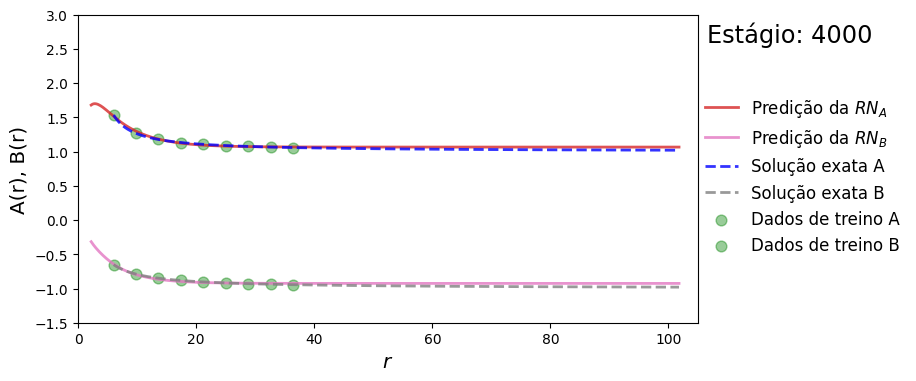

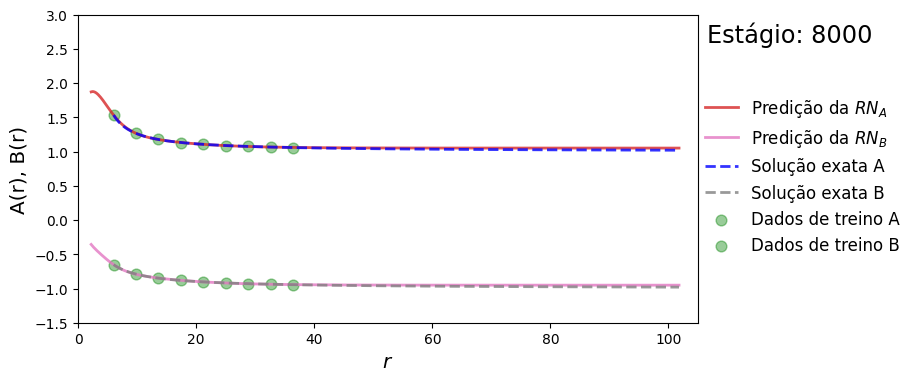

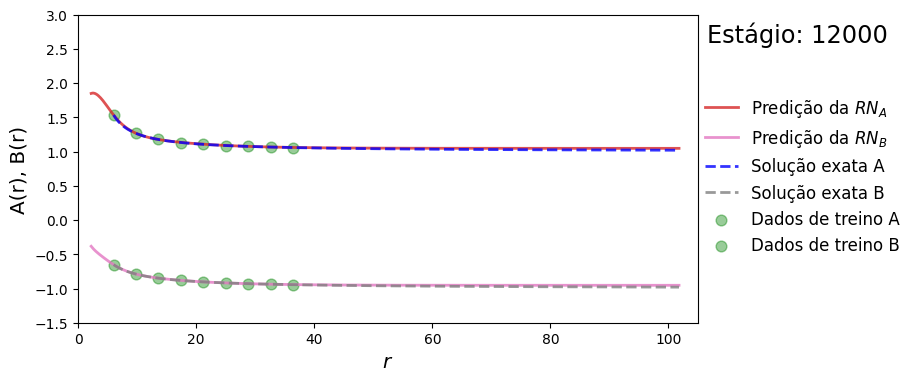

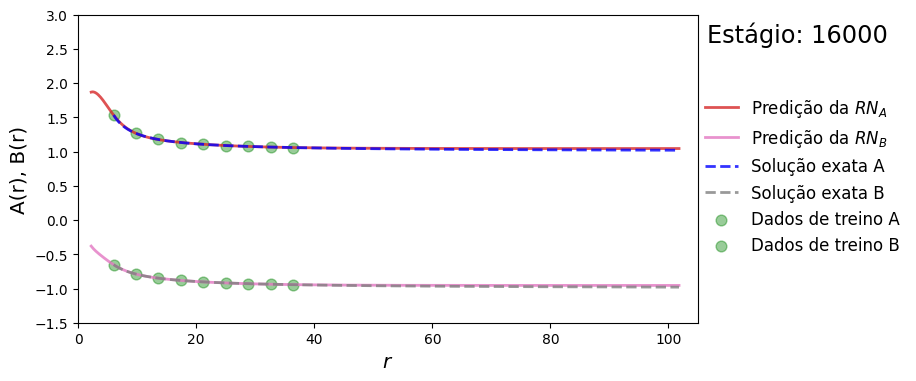

In [ ]:
# treina a rede neural padrão para ajustar os dados de treino

torch.manual_seed(7)
model = FCN(1,2,32,3)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
files = []

for i in range(16000):
    optimizer.zero_grad()
    y_pred = model(r_data)
    loss = torch.mean((y_pred - y_data)**2)  # erro quadrático médio
    loss.backward()
    optimizer.step()

    # grafica os resultados dos estágios do treino

    if (i+1) % 100 == 0:
        y_pred = model(r).detach()
        plot_result(r, y, r_data, y_data, y_pred, r_pred = None)
        if (i+1) % 4000 == 0: plt.show()
        else: plt.close("all")

Observe que a rede neural padrão conseguiu fazer previsões da solução exata além dos dados de treino fornecidos. Porém, à medida que nos aproximamos da origem, como a solução tem um fator que decresce com $1/r$, a aproximação da solução exata não foi boa.

# **Treino da PINN**

Escolhemos $40$ pontos de colocação uniformemente espaçados no domínio do problema. Fazemos de forma análoga ao caso do OHA e os parâmetros do modelo são: $model = FCN(1, 2, 32, 3)$, o número de épocas: $20.000$ e aumentamos o learning rate para $7e^{-4}$.

Neste trabalho utilizamos  $9$  dados da solução exata para treinar uma PINN. Além disso, utilizamos como dados de entrada as EDOs para penalizar a rede. Por se tratar de um problema mais complexo e termos um sistema de EDOs com suas particularidades, por exemplo, lidar com termos que divergem no limite do raio de Schwarzschild, vamos deixar para futuros trabalhos configurar uma PINN que envolva somente as condições de contorno e as EDOs.

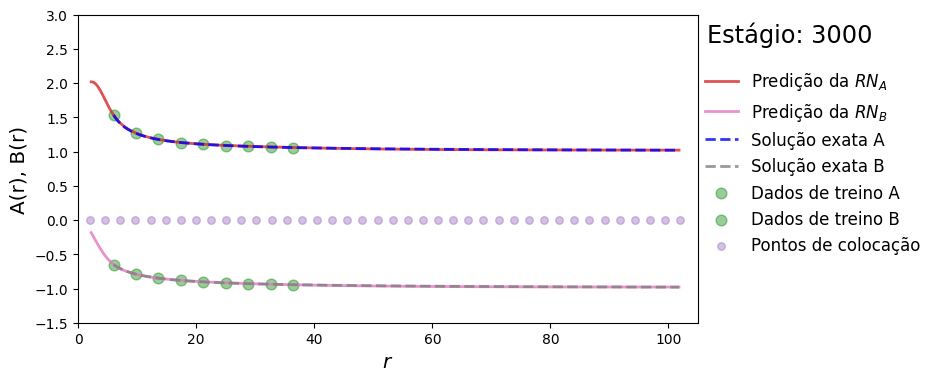

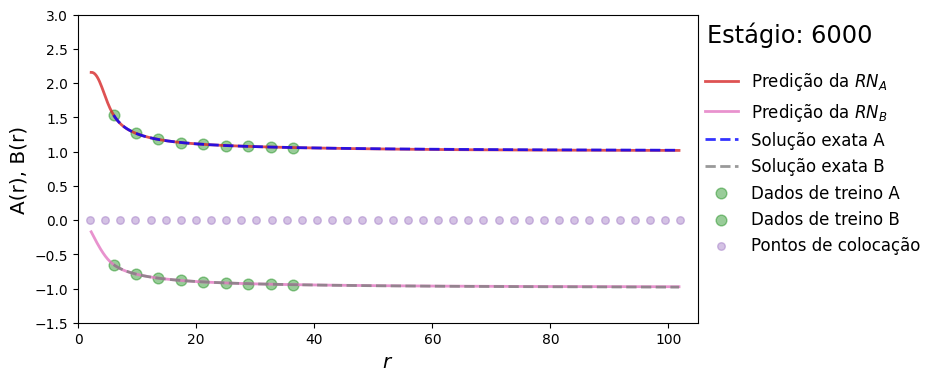

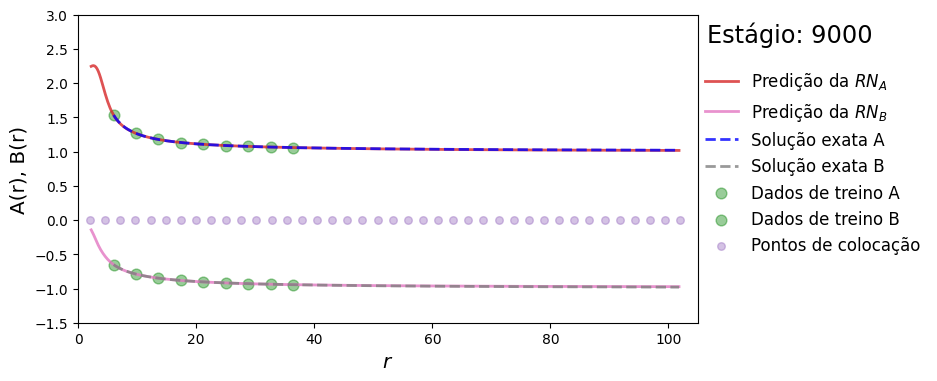

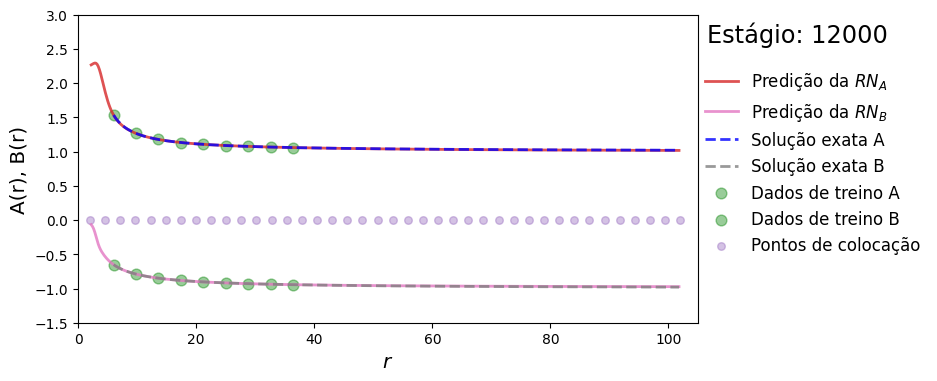

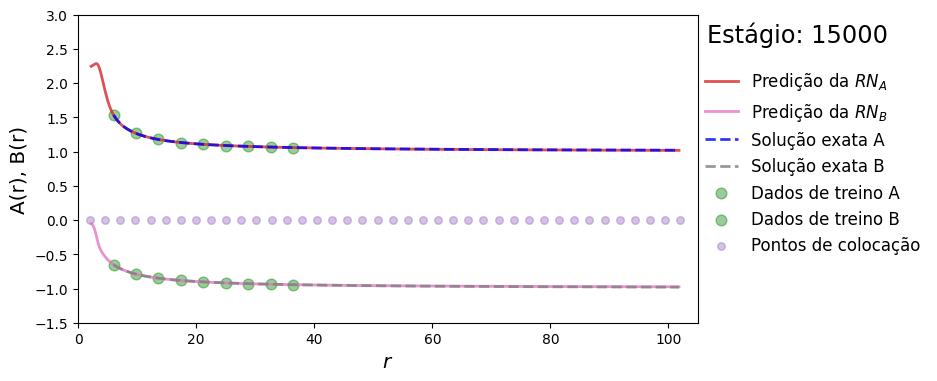

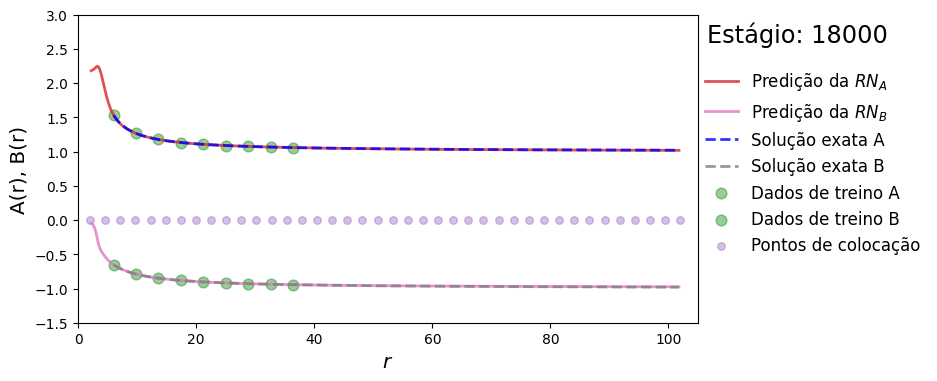

In [ ]:
# configuração do treino da PINN

torch.manual_seed(7)
model = FCN(1,2,42,4)
optimizer = torch.optim.Adam(model.parameters(), lr = 7e-4)

files = []
loss1_history = []
loss2_history = []
loss_history = []

mse_p1_history = []
mse_p2_history = []
mae_p1_history = []
mae_p2_history = []
r2_p1_history = []
r2_p2_history = []

# loop de treino

for i in range(20000):
    optimizer.zero_grad()

    r_physics = torch.linspace(2, 102, 40).view(-1,1).requires_grad_(True)

    # calcula o "data loss"

    y_pred = model(r_data)
    loss1 = torch.mean((y_pred - y_data)**2)  # erro quadrático médio

    # calcula a "physics loss"

    y_pred_p = model(r_physics)
    y_pred_p1 = y_pred_p[:,0].view(-1,1)
    y_pred_p2 = y_pred_p[:,1].view(-1,1)

    # calcula as derivadas

    dx1 = torch.autograd.grad(y_pred_p1, r_physics, torch.ones_like(y_pred_p1), create_graph = True)[0]
    dx2 = torch.autograd.grad(y_pred_p2, r_physics, torch.ones_like(y_pred_p2), create_graph = True)[0]
    ddx2 = torch.autograd.grad(dx2, r_physics, torch.ones_like(dx2), create_graph = True)[0]

    # calcula o resíduo

    physics1 = 4*dx1*y_pred_p2**2 - 2*r_physics*y_pred_p1*y_pred_p2*ddx2 + r_physics*dx1*y_pred_p2*dx2 + r_physics*y_pred_p1*dx2**2
    physics2 = -2*r_physics*y_pred_p1*y_pred_p2*ddx2 + r_physics*dx1*y_pred_p2*dx2 + r_physics*y_pred_p1*dx2**2 - 4*y_pred_p1*y_pred_p2*dx2
    physics3 = r_physics*dx1*y_pred_p2 + 2*y_pred_p1**2*y_pred_p2 - 2*y_pred_p1*y_pred_p2 - r_physics*y_pred_p1*dx2

    loss2 = torch.mean((physics1)**2) + torch.mean((physics2)**2) + torch.mean((physics3)**2)

    # backpropagate da loss total

    loss = loss1 + (9e-3)*loss2
    loss.backward()
    optimizer.step()

    # grafica o resultado dos estágios do treino

    if (i+1) % 100 == 0:
        loss1_history.append(loss1.detach())
        loss2_history.append(loss2.detach())
        loss_history.append(loss.detach())

        y_pred = model(r).detach()
        r_pred = r_physics.detach()

        y_pred_p = model(r)

        y_pred_p_p1 = y_pred_p[:,0].view(-1,1)
        y_pred_p_p2 = y_pred_p[:,1].view(-1,1)

        # erro quadrático médio

        mse_p1 = torch.mean((y_pred_p_p1 - A)**2)
        mse_p1_history.append(mse_p1.detach())
        # print('MSE(A)', mse_p1)

        mse_p2 = torch.mean((y_pred_p_p2 - B)**2)
        mse_p2_history.append(mse_p2.detach())
        # print('MSE(B)', mse_p2)

        # erro absoluto médio

        mae_p1 = torch.mean(torch.abs(y_pred_p_p1 - A))
        mae_p1_history.append(mae_p1.detach())
        # print('MAE(A)', mae_p1)

        mae_p2 = torch.mean(torch.abs(y_pred_p_p2 - B))
        mae_p2_history.append(mae_p2.detach())
        # print('MAE(B)', mae_p2)

        # fator R^2

        res_p1 = torch.sum((y_pred_p_p1 - A)**2)
        tot_p1 = torch.sum((torch.mean(A) - A)**2)
        r2_p1 = 1 - res_p1/tot_p1
        r2_p1_history.append(r2_p1.detach())
        # print('Desvio', res_p1)
        # print('Total', tot_p1)
        # print('R2(A)', r2_p1)

        res_p2 = torch.sum((y_pred_p_p2 - B)**2)
        tot_p2 = torch.sum((torch.mean(B) - B)**2)
        r2_p2 = 1 - res_p2/tot_p2
        r2_p2_history.append(r2_p2.detach())
        # print('R2(B)', r2_p2)

        plot_result(r, y, r_data, y_data, y_pred, r_pred)

        if (i+1) % 3000 == 0: plt.show()
        else: plt.close("all")

**Função A(r):**
- Os dados previstos para a solução na origem não são muito bons devido ao limite assintótico do raio de Schwarzschild e à imprecisão numérica para lidar com termos que decrescem com $1/r$. Uma estratégia numérica para lidar com esse problema é escolher pontos de colocação menos espaçados entre si à medida que nos aproximamos da origem. No sentido de que uma melhor "resolução" do grid no eixo da coordenada radial aumenta a precisão numérica. Note que no nosso caso os pontos de colocação estão uniformemente espaçados.
- À medida que nos afastamos da origem a solução prevista pela rede neural sobrepõe muito bem a solução exata e tende a $1$ como era esperado.


**Função B(r):**
- Um pouco melhor que no caso da função $A(r)$, note que próximo da origem a solução prevista pela rede neural é relativamente boa.
- À medida que nos afastamos da origem a solução prevista pela rede neural sobrepõe muito bem a solução exata e tende a $-1$ como era esperado, logo, ambas soluções satisfazem as condições de contorno.

Para testar a acurácia do modelo vamos analisar as métricas $MSE$, $MAE$ e o fator $R^2$ comparados com a evolução da Função Loss.

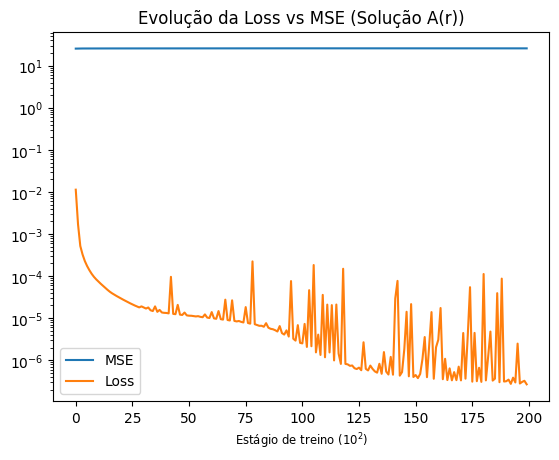

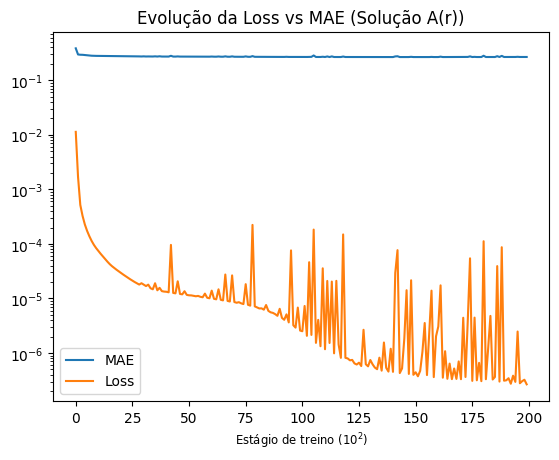

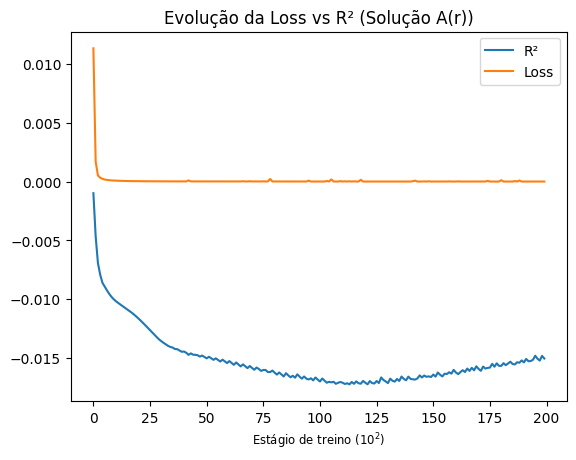

In [ ]:
fig1 = plt.figure(1)
plt.plot(mse_p1_history, label = "MSE")
plt.plot(loss_history, label = "Loss")
plt.title("Evolução da Loss vs MSE (Solução A(r))")
plt.xlabel("Estágio de treino ($10^2$)", fontsize = "small")
plt.yscale("log")
plt.legend()

fig2 = plt.figure(2)
plt.plot(mae_p1_history, label = "MAE")
plt.plot(loss_history, label = "Loss")
plt.title("Evolução da Loss vs MAE (Solução A(r))")
plt.xlabel("Estágio de treino ($10^2$)", fontsize = "small")
plt.yscale("log")
plt.legend()

fig3 = plt.figure(3)
plt.plot(r2_p1_history, label = "R²")
plt.plot(loss_history, label = "Loss")
plt.title("Evolução da Loss vs R² (Solução A(r))")
plt.xlabel("Estágio de treino ($10^2$)", fontsize = "small")
#plt.yscale("log")
plt.legend()

Note que os erros variam muito pouco e tendem a $0$, logo, podemos dizer que a rede neural obteve boas previsões para a solução de Schwarzschild. Porém, os valores do fator $R^2$ foram ruins, pois tendem a valores negativos e próximos de $0$. Isso acontece porque as condições de contorno na origem levam a divergências físicas e numéricas, uma vez que estamos tratando com valores próximos ao raio de Schwarzschild. Mas note que longe da origem a rede neural prevê dados que sobrepõem muito bem a solução exata já conhecida.

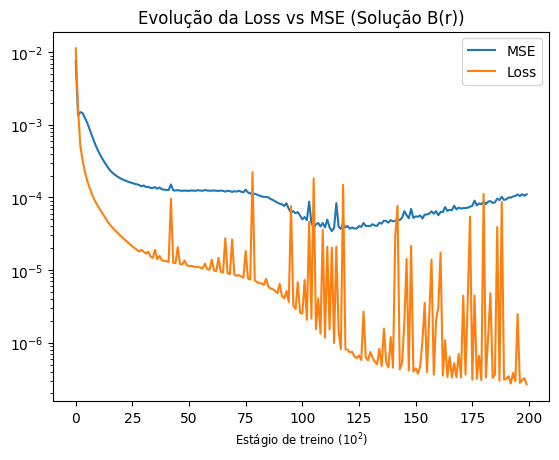

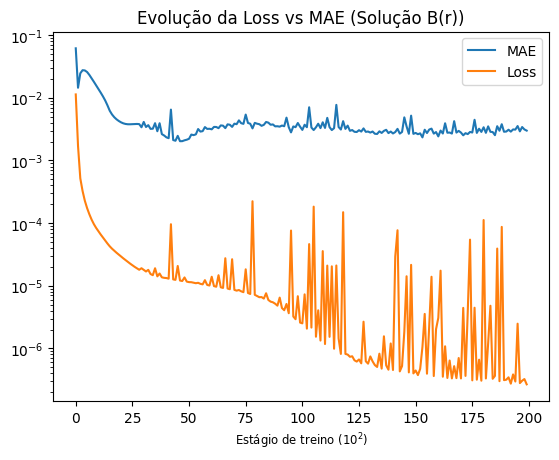

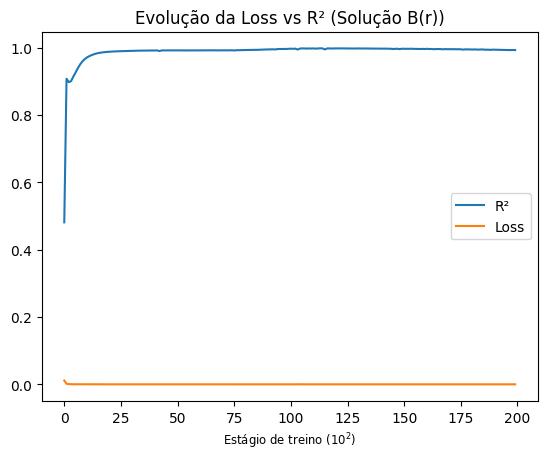

In [ ]:
fig4 = plt.figure(4)
plt.plot(mse_p2_history, label = "MSE")
plt.plot(loss_history, label = "Loss")
plt.title("Evolução da Loss vs MSE (Solução B(r))")
plt.xlabel("Estágio de treino ($10^2$)", fontsize = "small")
plt.yscale("log")
plt.legend()

fig5 = plt.figure(5)
plt.plot(mae_p2_history, label = "MAE")
plt.plot(loss_history, label = "Loss")
plt.title("Evolução da Loss vs MAE (Solução B(r))")
plt.xlabel("Estágio de treino ($10^2$)", fontsize = "small")
plt.yscale("log")
plt.legend()

fig6 = plt.figure(6)
plt.plot(r2_p2_history, label = "R²")
plt.plot(loss_history, label = "Loss")
plt.title("Evolução da Loss vs R² (Solução B(r))")
plt.xlabel("Estágio de treino ($10^2$)", fontsize = "small")
plt.legend()

Note que o fator $R^2$ tende a $1$ à medida que a Loss tende a $0$, logo, a regressão é muito boa. Isso também é notado quando constatamos que a precisão da solução encontrada é da ordem de $10^{-3}$ para o $MSE$ e $10^{-2}$ para o $MAE$.

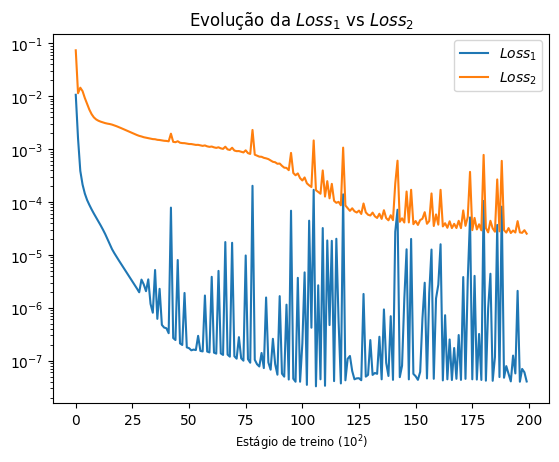

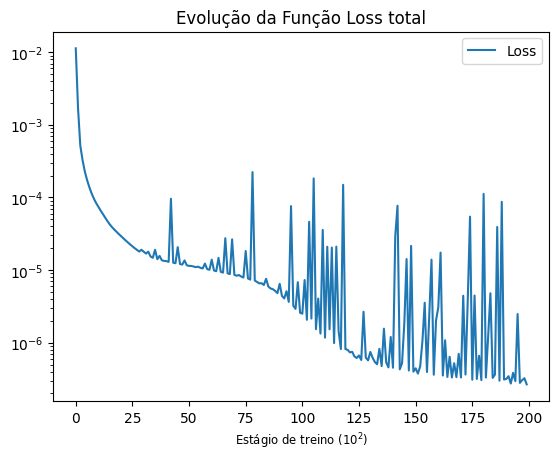

In [ ]:
fig4 = plt.figure(4)
plt.plot(loss1_history, label = "$Loss_1$")
plt.plot(loss2_history, label = "$Loss_2$")
plt.title("Evolução da $Loss_1$ vs $Loss_2$")
plt.xlabel("Estágio de treino ($10^2$)", fontsize = "small")
plt.yscale("log")
plt.legend()

fig5 = plt.figure(5)
plt.plot(loss_history, label = "Loss")
plt.title("Evolução da Função Loss total")
plt.xlabel("Estágio de treino ($10^2$)", fontsize = "small")
plt.yscale("log")
plt.legend()

O decaimento da Função Loss à medida que o número de épocas aumenta demonstra que o modelo está corretamente configurado, no sentido de que está sendo alcançada a minimização da Loss.

A maior dificuldade encontrada durante a configuração da rede neural foi escolher os dados de treino segundo as condições de contorno na origem. Note que a função $A(r)$ possui um termo que decresce com $1/r$, logo, ao selecionar pontos próximos da origem obtivemos uma grande divergência. Para contornar esse problema excluímos o primeiro ponto de colocação que era mais próximo da origem e treinamos a rede sem ele.

Além disso, outra particularidade do sistema de EDOs que leva à solução de Schwarzschild são as derivadas de 2da ordem. Numericamente isso pode ser um grande problema ao fazer com que os cálculos numéricos rapidamente divirjam. A abordagem encontrada na literatura para lidar com esta questão é redefinir o sistema de equações em termos de derivadas primeiras, o que leva ao aumento do número de EDOs a serem resolvidas.